# San Francisco Crime Classification
*Predict the category of crimes that occurred in the city by the bay*

[Kaggle Project Link](https://www.kaggle.com/c/sf-crime)

From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

We're also encouraging you to explore the dataset visually. What can we learn about the city through visualizations like this Top Crimes Map? The top most up-voted scripts from this competition will receive official Kaggle swag as prizes.

### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
from IPython.display import display
import toolz as t
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import random
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from sklearn.datasets import make_gaussian_quantiles

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

C:\Users\shane\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def return_all_rows(x):
    pd.set_option('display.max_rows', len(x))
    return x
    pd.reset_option('display.max_rows')
    
def return_all_columns(x):
    pd.set_option('display.max_columns', len(x))
    return x.head(5)
    pd.reset_option('display.max_columns')

### Exploratory Data Analysis

In [70]:
# Load training data
train = pd.read_csv('C:/Users/shane/Desktop/W207_Final/data/train.csv.zip', parse_dates=['Dates'])

# Load test data
test = pd.read_csv('C:/Users/shane/Desktop/W207_Final/data/test.csv.zip', parse_dates=['Dates'])

In [37]:
# Exploratory - Train - Review Dataset
train.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


#### Findings

    (1) 'Dates' column includes a good amount of detail -- year, month, and time of day. Additionally, there is a 'DayOfWeek' column which also includes the day of week. The 'Dates' column can be subset into three different columns though year likely won't be quite as useful unless we opt to weight more recent results to better incorporate trends. Though the time of year and day of the week will likely be useful since certain crimes are often more probably based on the season and day of the week.
    (2) The columns 'PdDistrict', 'Address', 'X', and 'Y' all refer to location. This will be beneficial since certain crimes will probably be more likely in certain district and will aid in classification. 'X' and 'Y' seem to be coordinates so those could potentially be concatenated and used to generate informative visualizations.
    (3) Furthermore, the 'Address' column seems to be specific to one location, block, or corner. Perhaps we can subset this information which will better classify crime based on the type of address information given. (i.e., vandalism will be more likely for an exact address while vehicle theft be more likely for a block).

In [4]:
# Exploratory - Train - Describe/Understand Values
train.describe(include='all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878049,878049,878049,878049,878049,878049,878049,878049.000000,878049.000000
unique,389257,39,879,7,10,17,23228,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174900,60022,133734,157182,526790,26533,NaN,NaN
first,2003-01-06 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-05-13 23:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422616,37.771020
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030354,0.456893
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427


#### Findings

    (1) Dates are obviously producing non-numeric values since it includes too much information.
    (2) There are (39) unique values in 'categories' but (879) unique values in 'Descript'. My assumption is that the number of unique descriptions can be reduced to prevent overfitting.
    (3) Only (10) PD districts -- great start for simplication. However, we might be able to find additional insights by clustering locations using the given coordinates.

In [5]:
train['Descript'].unique()

array(['WARRANT ARREST', 'TRAFFIC VIOLATION ARREST',
       'GRAND THEFT FROM LOCKED AUTO', 'GRAND THEFT FROM UNLOCKED AUTO',
       'STOLEN AUTOMOBILE', 'PETTY THEFT FROM LOCKED AUTO',
       'MISCELLANEOUS INVESTIGATION',
       'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES', 'FOUND PROPERTY',
       'ROBBERY, ARMED WITH A KNIFE',
       'AGGRAVATED ASSAULT WITH BODILY FORCE', 'TRAFFIC VIOLATION',
       'ROBBERY, BODILY FORCE', 'STAY AWAY OR COURT ORDER, NON-DV RELATED',
       'LOST PROPERTY', 'ATTEMPTED THEFT FROM LOCKED VEHICLE',
       'CIVIL SIDEWALKS, CITATION', 'MALICIOUS MISCHIEF, VANDALISM',
       'SUSPICIOUS PACKAGE', 'AIDED CASE, MENTAL DISTURBED',
       'PETTY THEFT SHOPLIFTING', 'PROBATION VIOLATION',
       'STAY AWAY ORDER VIOLATION, DV RELATED',
       'DRIVERS LICENSE, SUSPENDED OR REVOKED', 'STOLEN MOTORCYCLE',
       'GRAND THEFT FROM PERSON', 'BURGLARY, VEHICLE (ARREST MADE)',
       'ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE',
       'PETTY THEFT FROM A B

#### Findings

    (1) After further review, the "Descript" values are typically an elaboration of the crime category. For our purposes, it might be best to scrape this column to avoid overfitting.

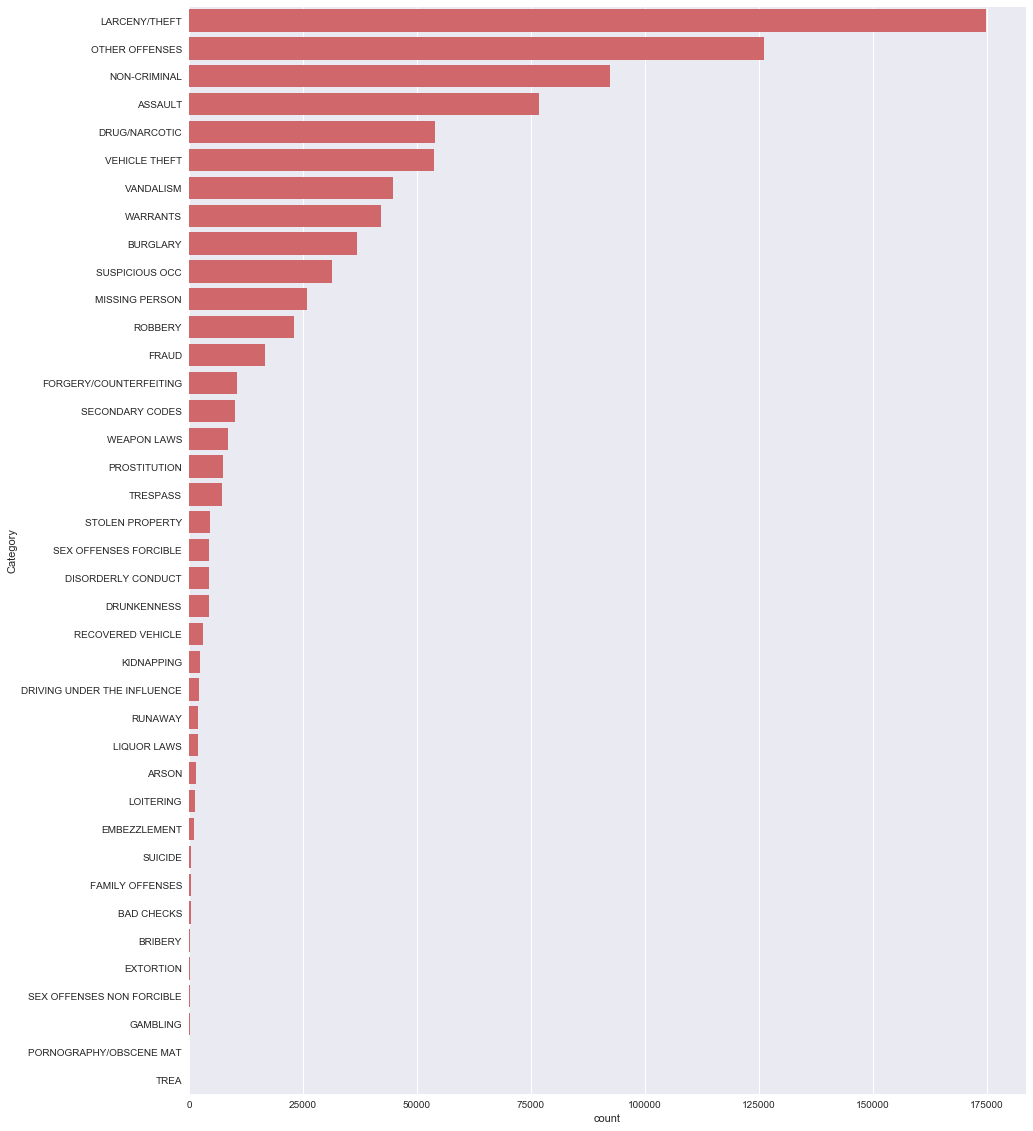

In [9]:
# Crime Category Frequency
red = ["#e15659"]
plt.figure(figsize=(15, 20))
sns.countplot(y=train['Category'], data=train, palette = sns.color_palette(red), order=train.Category.value_counts().index)

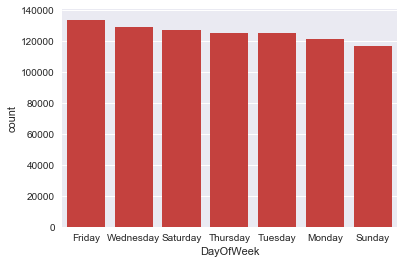

In [7]:
# Crime Frequency per Day of Week
sns.countplot(x=train['DayOfWeek'], data=train, palette = sns.color_palette(red), 
              order=train.DayOfWeek.value_counts().index)

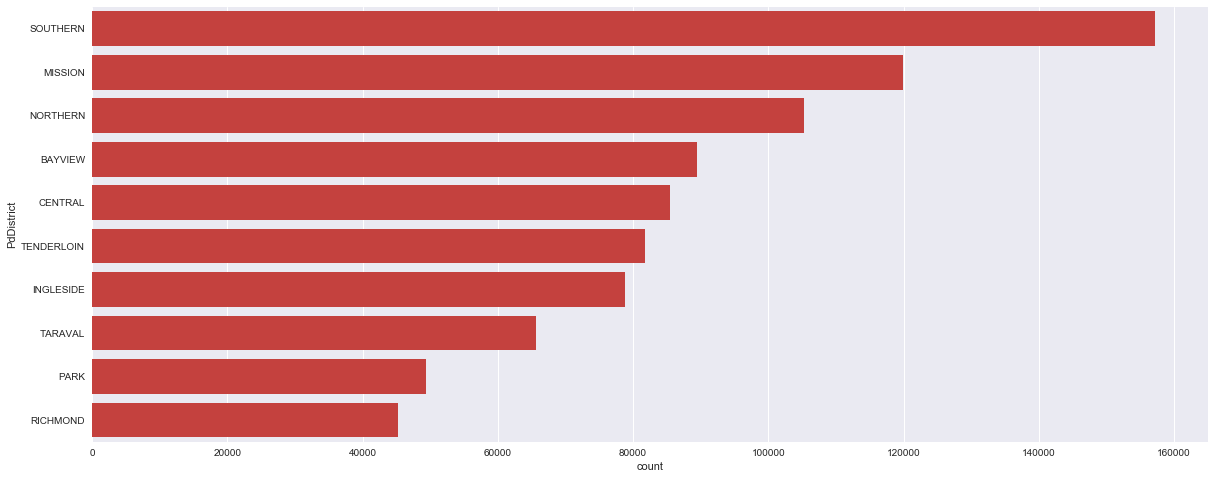

In [8]:
# District
plt.figure(figsize=(20, 8))
sns.countplot(y=train['PdDistrict'], data=train, palette = sns.color_palette(red), order=train.PdDistrict.value_counts().index)

### Cleaning & Enriching

In [71]:
# Clean - Train - Convert Labels
crimes = preprocessing.LabelEncoder()
labels = crimes.fit_transform(train.Category)

train['labels'] = labels

In [72]:
# Clean - Train/Test - Convert to date-time

# Train
train['Dates'] = pd.to_datetime(train['Dates'])
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['Hour'] = train['Dates'].dt.hour
train['Minute'] = train['Dates'].dt.minute

# Test
test['Dates'] = pd.to_datetime(test['Dates'])
test['Year'] = test['Dates'].dt.year
test['Month'] = test['Dates'].dt.month
test['Hour'] = test['Dates'].dt.hour
test['Minute'] = test['Dates'].dt.minute 

In [73]:
# Enrich - Train/Test - Month Dummy Variablees

# Train
months =  pd.get_dummies(train.Month, prefix="month_")
train  = pd.concat([train, months], axis=1)

# Test
months =  pd.get_dummies(test.Month, prefix="month_")
test  = pd.concat([test, months], axis=1)

In [74]:
# Enrich - Train/Test - Hour Dummy Variablees

# Train
hours =  pd.get_dummies(train.Hour, prefix="hour_")
train  = pd.concat([train, hours], axis=1)

# Test
hours =  pd.get_dummies(test.Hour, prefix="hour_")
test  = pd.concat([test, hours], axis=1)

In [75]:
# Enrich - Train/Test - Day of Week Dummy Variablees

# Train
days =  pd.get_dummies(train.DayOfWeek)
train  = pd.concat([train, days], axis=1)

# Test
days =  pd.get_dummies(test.DayOfWeek)
test  = pd.concat([test, days], axis=1)

In [76]:
# Enrich - Train/Test - PdDistrict Dummy Variables

# Train
PdDistricts =  pd.get_dummies(train.PdDistrict)
train  = pd.concat([train, PdDistricts], axis=1)

# Test
PdDistricts =  pd.get_dummies(test.PdDistrict)
test  = pd.concat([test, PdDistricts], axis=1)

In [77]:
# Enrich - Train/Test - Block vs Corner

# Train
train['Address'] = train['Address'].str.lower()
train['Corner'] = train['Address'].apply(lambda x: 1 if "/" in x else 0)
train['Block'] = train['Address'].apply(lambda x: 1 if "block" in x else 0)

# Test
test['Address'] = test['Address'].str.lower()
test['Corner'] = test['Address'].apply(lambda x: 1 if "/" in x else 0)
test['Block'] = test['Address'].apply(lambda x: 1 if "block" in x else 0)

In [78]:
return_all_columns(train)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,labels,Year,Month,Hour,Minute,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,hour__0,hour__1,hour__2,hour__3,hour__4,hour__5,hour__6,hour__7,hour__8,hour__9,hour__10,hour__11,hour__12,hour__13,hour__14,hour__15,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Corner,Block
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",oak st / laguna st,-122.425892,37.774599,37,2015,5,23,53,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",oak st / laguna st,-122.425892,37.774599,21,2015,5,23,53,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",vanness av / greenwich st,-122.424363,37.800414,21,2015,5,23,33,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 block of lombard st,-122.426995,37.800873,16,2015,5,23,30,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 block of broderick st,-122.438738,37.771541,16,2015,5,23,30,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [79]:
return_all_rows(train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
X,878049.0,-122.422616,0.030354,-122.513642,-122.432952,-122.416420,-122.406959,-120.5
Y,878049.0,37.771020,0.456893,37.707879,37.752427,37.775421,37.784369,90.0
labels,878049.0,19.338687,10.688637,0.000000,16.000000,20.000000,25.000000,38.0
Year,878049.0,2008.712046,3.631194,2003.000000,2006.000000,2009.000000,2012.000000,2015.0
Month,878049.0,6.436509,3.428972,1.000000,3.000000,6.000000,9.000000,12.0
Hour,878049.0,13.412655,6.549573,0.000000,9.000000,14.000000,19.000000,23.0
Minute,878049.0,20.155026,18.594915,0.000000,0.000000,19.000000,33.000000,59.0
month__1,878049.0,0.083749,0.277012,0.000000,0.000000,0.000000,0.000000,1.0
month__2,878049.0,0.080648,0.272294,0.000000,0.000000,0.000000,0.000000,1.0
month__3,878049.0,0.086920,0.281718,0.000000,0.000000,0.000000,0.000000,1.0


In [80]:
list(train.columns.values)

['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'labels',
 'Year',
 'Month',
 'Hour',
 'Minute',
 'month__1',
 'month__2',
 'month__3',
 'month__4',
 'month__5',
 'month__6',
 'month__7',
 'month__8',
 'month__9',
 'month__10',
 'month__11',
 'month__12',
 'hour__0',
 'hour__1',
 'hour__2',
 'hour__3',
 'hour__4',
 'hour__5',
 'hour__6',
 'hour__7',
 'hour__8',
 'hour__9',
 'hour__10',
 'hour__11',
 'hour__12',
 'hour__13',
 'hour__14',
 'hour__15',
 'hour__16',
 'hour__17',
 'hour__18',
 'hour__19',
 'hour__20',
 'hour__21',
 'hour__22',
 'hour__23',
 'Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'BAYVIEW',
 'CENTRAL',
 'INGLESIDE',
 'MISSION',
 'NORTHERN',
 'PARK',
 'RICHMOND',
 'SOUTHERN',
 'TARAVAL',
 'TENDERLOIN',
 'Corner',
 'Block']

In [86]:
X = ['month__1',
         'month__2',
         'month__3',
         'month__4',
         'month__5',
         'month__6',
         'month__7',
         'month__8',
         'month__9',
         'month__10',
         'month__11',
         'month__12',
         'hour__0',
         'hour__1',
         'hour__2',
         'hour__3',
         'hour__4',
         'hour__5',
         'hour__6',
         'hour__7',
         'hour__8',
         'hour__9',
         'hour__10',
         'hour__11',
         'hour__12',
         'hour__13',
         'hour__14',
         'hour__15',
         'hour__16',
         'hour__17',
         'hour__18',
         'hour__19',
         'hour__20',
         'hour__21',
         'hour__22',
         'hour__23',
         'Friday',
         'Monday',
         'Saturday',
         'Sunday',
         'Thursday',
         'Tuesday',
         'Wednesday',
         'BAYVIEW',
         'CENTRAL',
         'INGLESIDE',
         'MISSION',
         'NORTHERN',
         'PARK',
         'RICHMOND',
         'SOUTHERN',
         'TARAVAL',
         'TENDERLOIN',
         'Corner',
         'Block']

In [82]:
# df - Subset - Relevant features with adequate data
training, dev = train_test_split(train, train_size=0.7)

In [92]:
training, validation = train_test_split(train, train_size=.60)
model = BernoulliNB()
model.fit(training[X], training['labels'])
predicted = np.array(model.predict_proba(validation[X]))
log_loss(validation['labels'], predicted) 

2.5706936570295831

In [90]:
dev[X]

,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,hour__0,hour__1,hour__2,hour__3,hour__4,hour__5,hour__6,hour__7,hour__8,hour__9,hour__10,hour__11,hour__12,hour__13,hour__14,hour__15,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Corner,Block
295802,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
850560,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
178662,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
334633,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
534474,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
186092,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
252906,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
620599,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
560698,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
479730,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [87]:
model = BernoulliNB()
model.fit(training[X], training['labels'])
predicted = np.array(model.predict_proba(dev[X]))
log_loss(dev['labels'], predicted)

ValueError: y_true and y_pred contain different number of classes 38, 39. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38]

In [12]:
# Review changes
#train.head(5)
train.describe(include='all')
train.to_csv(path_or_buf = 'C:/MIDS/W207/w207_final/train.csv') 

### Training

### Random Forests

#### Using default parameters

In [14]:
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
                             n_jobs=3, random_state=None, verbose=0, warm_start=False, class_weight=None)
rfc.fit(X_train, Y_train)

rfc.score(X_dev,Y_dev)

0.28721598997779169

#### Changing criterion = entropy 

In [19]:
rfc = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
                             n_jobs=3, random_state=None, verbose=0, warm_start=False, class_weight=None)
rfc.fit(X_train, Y_train)

rfc.score(X_dev,Y_dev)

0.28646432435510505

#### Using n_estimators = 20 instead of 10

In [20]:
rfc = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None, min_samples_split=4, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
                             n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)
rfc.fit(X_train, Y_train)

rfc.score(X_dev,Y_dev)

0.30431068845737713

#### Using n_estimators = 100 instead of 10

In [15]:
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=4, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
                             n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)
rfc.fit(X_train, Y_train)

rfc.score(X_dev,Y_dev)

0.3160108573923277

#### Using Logistic Regression